<a href="https://colab.research.google.com/github/brngl/CausalLSTM-Keras/blob/master/Keras_Causal_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install tensorflow==2.0

In [2]:
from google.colab import drive
from google.colab import files
import sys
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Tesi Angelo Maiorano 160178/Codice/predrnn-pp-master'

sys.path.append(root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!drive.mount("/content/gdrive", force_remount=True)
!ls
%cd 'gdrive'
%cd 'My Drive'
%cd 'Tesi Angelo Maiorano 160178'
%cd 'Codice'
%cd 'predrnn-pp-master'
!ls

/bin/bash: -c: line 0: syntax error near unexpected token `"/content/gdrive",'
/bin/bash: -c: line 0: `drive.mount("/content/gdrive", force_remount=True)'
gdrive	sample_data
/content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/Tesi Angelo Maiorano 160178
/content/gdrive/My Drive/Tesi Angelo Maiorano 160178/Codice
/content/gdrive/My Drive/Tesi Angelo Maiorano 160178/Codice/predrnn-pp-master
 checkpoints		     etapred.txt		 prova.py
 checkpoints-pred	     etarec.txt			 README.md
 ciaone.png		     eta.txt			 results
'Copia di losses_list.txt'   layers			 results-pred
 data			     losses_list.txt		 train.py
 data_provider		     nets			 utils
 data_provider-pred	     new_training-set-shuf.npz
 eta.npy		     os.path


In [4]:
%cd data/
%cd ano-moving-mnist/
%ls 

/content/gdrive/My Drive/Tesi Angelo Maiorano 160178/Codice/predrnn-pp-master/data
/content/gdrive/My Drive/Tesi Angelo Maiorano 160178/Codice/predrnn-pp-master/data/ano-moving-mnist
anom_test.npz             just-temporal.npz  new_training-set.npz
anom_train.npz            k15-solouno.npz    test-results/
anom_valid.npz            k300-entrambi.npz  uniqueanomovingmnist-test.npz
equal_sfarfa_testset.npz  k30-entrambi.npz   valid_train.npz


# Inizio

In [5]:
import tensorflow as tf
import keras
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import _standardize_args
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from keras.legacy import interfaces
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export
print(tf.__version__)

2.0.0


Using TensorFlow backend.


#Versione

In [6]:
tf.__version__

'2.0.0'

In [0]:
class ConvRNN2D(RNN):
  """Base class for convolutional-recurrent layers.
  Arguments:
    cell: A RNN cell instance. A RNN cell is a class that has:
      - a `call(input_at_t, states_at_t)` method, returning
        `(output_at_t, states_at_t_plus_1)`. The call method of the
        cell can also take the optional argument `constants`, see
        section "Note on passing external constants" below.
      - a `state_size` attribute. This can be a single integer
        (single state) in which case it is
        the number of channels of the recurrent state
        (which should be the same as the number of channels of the cell
        output). This can also be a list/tuple of integers
        (one size per state). In this case, the first entry
        (`state_size[0]`) should be the same as
        the size of the cell output.
    return_sequences: Boolean. Whether to return the last output.
      in the output sequence, or the full sequence.
    return_state: Boolean. Whether to return the last state
      in addition to the output.
    go_backwards: Boolean (default False).
      If True, process the input sequence backwards and return the
      reversed sequence.
    stateful: Boolean (default False). If True, the last state
      for each sample at index i in a batch will be used as initial
      state for the sample of index i in the following batch.
    input_shape: Use this argument to specify the shape of the
      input when this layer is the first one in a model.
  Call arguments:
    inputs: A 5D tensor.
    mask: Binary tensor of shape `(samples, timesteps)` indicating whether
      a given timestep should be masked.
    training: Python boolean indicating whether the layer should behave in
      training mode or in inference mode. This argument is passed to the cell
      when calling it. This is for use with cells that use dropout.
    initial_state: List of initial state tensors to be passed to the first
      call of the cell.
    constants: List of constant tensors to be passed to the cell at each
      timestep.
  Input shape:
    5D tensor with shape:
    `(samples, timesteps, channels, rows, cols)`
    if data_format='channels_first' or 5D tensor with shape:
    `(samples, timesteps, rows, cols, channels)`
    if data_format='channels_last'.
  Output shape:
    - If `return_state`: a list of tensors. The first tensor is
      the output. The remaining tensors are the last states,
      each 4D tensor with shape:
      `(samples, filters, new_rows, new_cols)`
      if data_format='channels_first'
      or 4D tensor with shape:
      `(samples, new_rows, new_cols, filters)`
      if data_format='channels_last'.
      `rows` and `cols` values might have changed due to padding.
    - If `return_sequences`: 5D tensor with shape:
      `(samples, timesteps, filters, new_rows, new_cols)`
      if data_format='channels_first'
      or 5D tensor with shape:
      `(samples, timesteps, new_rows, new_cols, filters)`
      if data_format='channels_last'.
    - Else, 4D tensor with shape:
      `(samples, filters, new_rows, new_cols)`
      if data_format='channels_first'
      or 4D tensor with shape:
      `(samples, new_rows, new_cols, filters)`
      if data_format='channels_last'.
  Masking:
    This layer supports masking for input data with a variable number
    of timesteps.
  Note on using statefulness in RNNs:
    You can set RNN layers to be 'stateful', which means that the states
    computed for the samples in one batch will be reused as initial states
    for the samples in the next batch. This assumes a one-to-one mapping
    between samples in different successive batches.
    To enable statefulness:
      - Specify `stateful=True` in the layer constructor.
      - Specify a fixed batch size for your model, by passing
         - If sequential model:
            `batch_input_shape=(...)` to the first layer in your model.
         - If functional model with 1 or more Input layers:
            `batch_shape=(...)` to all the first layers in your model.
            This is the expected shape of your inputs
            *including the batch size*.
            It should be a tuple of integers,
            e.g. `(32, 10, 100, 100, 32)`.
            Note that the number of rows and columns should be specified
            too.
      - Specify `shuffle=False` when calling fit().
    To reset the states of your model, call `.reset_states()` on either
    a specific layer, or on your entire model.
  Note on specifying the initial state of RNNs:
    You can specify the initial state of RNN layers symbolically by
    calling them with the keyword argument `initial_state`. The value of
    `initial_state` should be a tensor or list of tensors representing
    the initial state of the RNN layer.
    You can specify the initial state of RNN layers numerically by
    calling `reset_states` with the keyword argument `states`. The value of
    `states` should be a numpy array or list of numpy arrays representing
    the initial state of the RNN layer.
  Note on passing external constants to RNNs:
    You can pass "external" constants to the cell using the `constants`
    keyword argument of `RNN.__call__` (as well as `RNN.call`) method. This
    requires that the `cell.call` method accepts the same keyword argument
    `constants`. Such constants can be used to condition the cell
    transformation on additional static inputs (not changing over time),
    a.k.a. an attention mechanism.
  """

  def __init__(self,
               cell,
               return_sequences=False,
               return_state=False,
               go_backwards=False,
               stateful=False,
               unroll=False,
               **kwargs):
    if unroll:
      raise TypeError('Unrolling isn\'t possible with '
                      'convolutional RNNs.')
    if isinstance(cell, (list, tuple)):
      # The StackedConvRNN2DCells isn't implemented yet.
      raise TypeError('It is not possible at the moment to'
                      'stack convolutional cells.')
    super(ConvRNN2D, self).__init__(cell,
                                    return_sequences,
                                    return_state,
                                    go_backwards,
                                    stateful,
                                    unroll,
                                    **kwargs)
    self.input_spec = [InputSpec(ndim=5)]
    self.states = None
    self._num_constants = None

  @tf_utils.shape_type_conversion
  def compute_output_shape(self, input_shape):
    if isinstance(input_shape, list):
      input_shape = input_shape[0]

    cell = self.cell
    if cell.data_format == 'channels_first':
      rows = input_shape[3]
      cols = input_shape[4]
    elif cell.data_format == 'channels_last':
      rows = input_shape[2]
      cols = input_shape[3]
    rows = conv_utils.conv_output_length(rows,
                                         cell.kernel_size[0],
                                         padding=cell.padding,
                                         stride=cell.strides[0],
                                         dilation=cell.dilation_rate[0])
    cols = conv_utils.conv_output_length(cols,
                                         cell.kernel_size[1],
                                         padding=cell.padding,
                                         stride=cell.strides[1],
                                         dilation=cell.dilation_rate[1])

    if cell.data_format == 'channels_first':
      output_shape = input_shape[:2] + (cell.filters, rows, cols)
    elif cell.data_format == 'channels_last':
      output_shape = input_shape[:2] + (rows, cols, cell.filters)

    if not self.return_sequences:
      output_shape = output_shape[:1] + output_shape[2:]

    if self.return_state:
      output_shape = [output_shape]
      if cell.data_format == 'channels_first':
        output_shape += [(input_shape[0], cell.filters, rows, cols)
                         for _ in range(2)]
      elif cell.data_format == 'channels_last':
        output_shape += [(input_shape[0], rows, cols, cell.filters)
                         for _ in range(2)]
    return output_shape

  @tf_utils.shape_type_conversion
  def build(self, input_shape):
    # Note input_shape will be list of shapes of initial states and
    # constants if these are passed in __call__.
    if self._num_constants is not None:
      constants_shape = input_shape[-self._num_constants:]  # pylint: disable=E1130
    else:
      constants_shape = None

    if isinstance(input_shape, list):
      input_shape = input_shape[0]

    batch_size = input_shape[0] if self.stateful else None
    self.input_spec[0] = InputSpec(shape=(batch_size, None) + input_shape[2:5])

    # allow cell (if layer) to build before we set or validate state_spec
    if isinstance(self.cell, Layer):
      step_input_shape = (input_shape[0],) + input_shape[2:]
      if constants_shape is not None:
        self.cell.build([step_input_shape] + constants_shape)
      else:
        self.cell.build(step_input_shape)

    # set or validate state_spec
    if hasattr(self.cell.state_size, '__len__'):
      state_size = list(self.cell.state_size)
    else:
      state_size = [self.cell.state_size]

    if self.state_spec is not None:
      # initial_state was passed in call, check compatibility
      if self.cell.data_format == 'channels_first':
        ch_dim = 1
      elif self.cell.data_format == 'channels_last':
        ch_dim = 3
      if [spec.shape[ch_dim] for spec in self.state_spec] != state_size:
        raise ValueError(
            'An initial_state was passed that is not compatible with '
            '`cell.state_size`. Received `state_spec`={}; '
            'However `cell.state_size` is '
            '{}'.format([spec.shape for spec in self.state_spec],
                        self.cell.state_size))
    else:
      if self.cell.data_format == 'channels_first':
        self.state_spec = [InputSpec(shape=(None, dim, None, None))
                           for dim in state_size]
      elif self.cell.data_format == 'channels_last':
        self.state_spec = [InputSpec(shape=(None, None, None, dim))
                           for dim in state_size]
    if self.stateful:
      self.reset_states()
    self.built = True

  def get_initial_state(self, inputs):
    # (samples, timesteps, rows, cols, filters)
    initial_state = K.zeros_like(inputs)
    # (samples, rows, cols, filters)
    initial_state = K.sum(initial_state, axis=1)
    shape = list(self.cell.kernel_shape)
    shape[-1] = self.cell.filters
    initial_state = self.cell.input_conv(initial_state,
                                         array_ops.zeros(tuple(shape)),
                                         padding=self.cell.padding)

    if hasattr(self.cell.state_size, '__len__'):
      return [initial_state for _ in self.cell.state_size]
    else:
      return [initial_state]

  def __call__(self, inputs, initial_state=None, constants=None, **kwargs):
    inputs, initial_state, constants = _standardize_args(
        inputs, initial_state, constants, self._num_constants)

    if initial_state is None and constants is None:
      return super(ConvRNN2D, self).__call__(inputs, **kwargs)

    # If any of `initial_state` or `constants` are specified and are Keras
    # tensors, then add them to the inputs and temporarily modify the
    # input_spec to include them.

    additional_inputs = []
    additional_specs = []
    if initial_state is not None:
      kwargs['initial_state'] = initial_state
      additional_inputs += initial_state
      self.state_spec = []
      for state in initial_state:
        shape = K.int_shape(state)
        self.state_spec.append(InputSpec(shape=shape))

      additional_specs += self.state_spec
    if constants is not None:
      kwargs['constants'] = constants
      additional_inputs += constants
      self.constants_spec = [InputSpec(shape=K.int_shape(constant))
                             for constant in constants]
      self._num_constants = len(constants)
      additional_specs += self.constants_spec
    # at this point additional_inputs cannot be empty
    for tensor in additional_inputs:
      if K.is_keras_tensor(tensor) != K.is_keras_tensor(additional_inputs[0]):
        raise ValueError('The initial state or constants of an RNN'
                         ' layer cannot be specified with a mix of'
                         ' Keras tensors and non-Keras tensors')

    if K.is_keras_tensor(additional_inputs[0]):
      # Compute the full input spec, including state and constants
      full_input = [inputs] + additional_inputs
      full_input_spec = self.input_spec + additional_specs
      # Perform the call with temporarily replaced input_spec
      original_input_spec = self.input_spec
      self.input_spec = full_input_spec
      output = super(ConvRNN2D, self).__call__(full_input, **kwargs)
      self.input_spec = original_input_spec
      return output
    else:
      return super(ConvRNN2D, self).__call__(inputs, **kwargs)

  def call(self,
           inputs,
           mask=None,
           training=None,
           initial_state=None,
           constants=None):
    # note that the .build() method of subclasses MUST define
    # self.input_spec and self.state_spec with complete input shapes.
    if isinstance(inputs, list):
      inputs = inputs[0]
    if initial_state is not None:
      pass
    elif self.stateful:
      initial_state = self.states
    else:
      initial_state = self.get_initial_state(inputs)

    if isinstance(mask, list):
      mask = mask[0]

    if len(initial_state) != len(self.states):
      raise ValueError('Layer has ' + str(len(self.states)) +
                       ' states but was passed ' +
                       str(len(initial_state)) +
                       ' initial states.')
    timesteps = K.int_shape(inputs)[1]

    kwargs = {}
    if generic_utils.has_arg(self.cell.call, 'training'):
      kwargs['training'] = training

    if constants:
      if not generic_utils.has_arg(self.cell.call, 'constants'):
        raise ValueError('RNN cell does not support constants')

      def step(inputs, states):
        constants = states[-self._num_constants:]
        states = states[:-self._num_constants]
        return self.cell.call(inputs, states, constants=constants,
                              **kwargs)
    else:
      def step(inputs, states):
        return self.cell.call(inputs, states, **kwargs)

    last_output, outputs, states = K.rnn(step,
                                         inputs,
                                         initial_state,
                                         constants=constants,
                                         go_backwards=self.go_backwards,
                                         mask=mask,
                                         input_length=timesteps)
    if self.stateful:
      updates = []
      for i in range(len(states)):
        updates.append(K.update(self.states[i], states[i]))
      self.add_update(updates)

    if self.return_sequences:
      output = outputs
    else:
      output = last_output

    if self.return_state:
      if not isinstance(states, (list, tuple)):
        states = [states]
      else:
        states = list(states)
      return [output] + states
    else:
      return output

  def reset_states(self, states=None):
    if not self.stateful:
      raise AttributeError('Layer must be stateful.')
    input_shape = self.input_spec[0].shape
    state_shape = self.compute_output_shape(input_shape)
    if self.return_state:
      state_shape = state_shape[0]
    if self.return_sequences:
      state_shape = state_shape[:1].concatenate(state_shape[2:])
    if None in state_shape:
      raise ValueError('If a RNN is stateful, it needs to know '
                       'its batch size. Specify the batch size '
                       'of your input tensors: \n'
                       '- If using a Sequential model, '
                       'specify the batch size by passing '
                       'a `batch_input_shape` '
                       'argument to your first layer.\n'
                       '- If using the functional API, specify '
                       'the time dimension by passing a '
                       '`batch_shape` argument to your Input layer.\n'
                       'The same thing goes for the number of rows and '
                       'columns.')

    # helper function
    def get_tuple_shape(nb_channels):
      result = list(state_shape)
      if self.cell.data_format == 'channels_first':
        result[1] = nb_channels
      elif self.cell.data_format == 'channels_last':
        result[3] = nb_channels
      else:
        raise KeyError
      return tuple(result)

    # initialize state if None
    if self.states[0] is None:
      if hasattr(self.cell.state_size, '__len__'):
        self.states = [K.zeros(get_tuple_shape(dim))
                       for dim in self.cell.state_size]
      else:
        self.states = [K.zeros(get_tuple_shape(self.cell.state_size))]
    elif states is None:
      if hasattr(self.cell.state_size, '__len__'):
        for state, dim in zip(self.states, self.cell.state_size):
          K.set_value(state, np.zeros(get_tuple_shape(dim)))
      else:
        K.set_value(self.states[0],
                    np.zeros(get_tuple_shape(self.cell.state_size)))
    else:
      if not isinstance(states, (list, tuple)):
        states = [states]
      if len(states) != len(self.states):
        raise ValueError('Layer ' + self.name + ' expects ' +
                         str(len(self.states)) + ' states, ' +
                         'but it received ' + str(len(states)) +
                         ' state values. Input received: ' + str(states))
      for index, (value, state) in enumerate(zip(states, self.states)):
        if hasattr(self.cell.state_size, '__len__'):
          dim = self.cell.state_size[index]
        else:
          dim = self.cell.state_size
        if value.shape != get_tuple_shape(dim):
          raise ValueError('State ' + str(index) +
                           ' is incompatible with layer ' +
                           self.name + ': expected shape=' +
                           str(get_tuple_shape(dim)) +
                           ', found shape=' + str(value.shape))
        # TODO(anjalisridhar): consider batch calls to `set_value`.
        K.set_value(state, value)


class ConvLSTM2DCell(DropoutRNNCellMixin, Layer):
  """Cell class for the ConvLSTM2D layer.
  Arguments:
    filters: Integer, the dimensionality of the output space
      (i.e. the number of output filters in the convolution).
    kernel_size: An integer or tuple/list of n integers, specifying the
      dimensions of the convolution window.
    strides: An integer or tuple/list of n integers,
      specifying the strides of the convolution.
      Specifying any stride value != 1 is incompatible with specifying
      any `dilation_rate` value != 1.
    padding: One of `"valid"` or `"same"` (case-insensitive).
    data_format: A string,
      one of `channels_last` (default) or `channels_first`.
      It defaults to the `image_data_format` value found in your
      Keras config file at `~/.keras/keras.json`.
      If you never set it, then it will be "channels_last".
    dilation_rate: An integer or tuple/list of n integers, specifying
      the dilation rate to use for dilated convolution.
      Currently, specifying any `dilation_rate` value != 1 is
      incompatible with specifying any `strides` value != 1.
    activation: Activation function to use.
      If you don't specify anything, no activation is applied
      (ie. "linear" activation: `a(x) = x`).
    recurrent_activation: Activation function to use
      for the recurrent step.
    use_bias: Boolean, whether the layer uses a bias vector.
    kernel_initializer: Initializer for the `kernel` weights matrix,
      used for the linear transformation of the inputs.
    recurrent_initializer: Initializer for the `recurrent_kernel`
      weights matrix,
      used for the linear transformation of the recurrent state.
    bias_initializer: Initializer for the bias vector.
    unit_forget_bias: Boolean.
      If True, add 1 to the bias of the forget gate at initialization.
      Use in combination with `bias_initializer="zeros"`.
      This is recommended in [Jozefowicz et al.]
      (http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf)
    kernel_regularizer: Regularizer function applied to
      the `kernel` weights matrix.
    recurrent_regularizer: Regularizer function applied to
      the `recurrent_kernel` weights matrix.
    bias_regularizer: Regularizer function applied to the bias vector.
    kernel_constraint: Constraint function applied to
      the `kernel` weights matrix.
    recurrent_constraint: Constraint function applied to
      the `recurrent_kernel` weights matrix.
    bias_constraint: Constraint function applied to the bias vector.
    dropout: Float between 0 and 1.
      Fraction of the units to drop for
      the linear transformation of the inputs.
    recurrent_dropout: Float between 0 and 1.
      Fraction of the units to drop for
      the linear transformation of the recurrent state.
  Call arguments:
    inputs: A 4D tensor.
    states:  List of state tensors corresponding to the previous timestep.
    training: Python boolean indicating whether the layer should behave in
      training mode or in inference mode. Only relevant when `dropout` or
      `recurrent_dropout` is used.
  """

  def __init__(self,
               filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    super(ConvLSTM2DCell, self).__init__(**kwargs)
    self.filters = filters
    self.kernel_size = conv_utils.normalize_tuple(kernel_size, 2, 'kernel_size')
    self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
    self.padding = conv_utils.normalize_padding(padding)
    self.data_format = conv_utils.normalize_data_format(data_format)
    self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, 2,
                                                    'dilation_rate')
    self.activation = activations.get(activation)
    self.recurrent_activation = activations.get(recurrent_activation)
    self.use_bias = use_bias

    self.kernel_initializer = initializers.get(kernel_initializer)
    self.recurrent_initializer = initializers.get(recurrent_initializer)
    self.bias_initializer = initializers.get(bias_initializer)
    self.unit_forget_bias = unit_forget_bias

    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
    self.bias_regularizer = regularizers.get(bias_regularizer)

    self.kernel_constraint = constraints.get(kernel_constraint)
    self.recurrent_constraint = constraints.get(recurrent_constraint)
    self.bias_constraint = constraints.get(bias_constraint)

    self.dropout = min(1., max(0., dropout))
    self.recurrent_dropout = min(1., max(0., recurrent_dropout))
    self.state_size = (self.filters, self.filters)

  def build(self, input_shape):

    if self.data_format == 'channels_first':
      channel_axis = 1
    else:
      channel_axis = -1
    if input_shape[channel_axis] is None:
      raise ValueError('The channel dimension of the inputs '
                       'should be defined. Found `None`.')
    input_dim = input_shape[channel_axis]
    kernel_shape = self.kernel_size + (input_dim, self.filters * 4)
    self.kernel_shape = kernel_shape
    recurrent_kernel_shape = self.kernel_size + (self.filters, self.filters * 4)

    self.kernel = self.add_weight(shape=kernel_shape,
                                  initializer=self.kernel_initializer,
                                  name='kernel',
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
    self.recurrent_kernel = self.add_weight(
        shape=recurrent_kernel_shape,
        initializer=self.recurrent_initializer,
        name='recurrent_kernel',
        regularizer=self.recurrent_regularizer,
        constraint=self.recurrent_constraint)

    if self.use_bias:
      if self.unit_forget_bias:

        def bias_initializer(_, *args, **kwargs):
          return K.concatenate([
              self.bias_initializer((self.filters,), *args, **kwargs),
              initializers.Ones()((self.filters,), *args, **kwargs),
              self.bias_initializer((self.filters * 2,), *args, **kwargs),
          ])
      else:
        bias_initializer = self.bias_initializer
      self.bias = self.add_weight(
          shape=(self.filters * 4,),
          name='bias',
          initializer=bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint)
    else:
      self.bias = None
    self.built = True

  def call(self, inputs, states, training=None):
    h_tm1 = states[0]  # previous memory state
    c_tm1 = states[1]  # previous carry state
    print("STATES", states)
    # dropout matrices for input units
    dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=4)
    # dropout matrices for recurrent units
    rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        h_tm1, training, count=4)

    if 0 < self.dropout < 1.:
      inputs_i = inputs * dp_mask[0]
      inputs_f = inputs * dp_mask[1]
      inputs_c = inputs * dp_mask[2]
      inputs_o = inputs * dp_mask[3]
    else:
      inputs_i = inputs
      inputs_f = inputs
      inputs_c = inputs
      inputs_o = inputs

    if 0 < self.recurrent_dropout < 1.:
      h_tm1_i = h_tm1 * rec_dp_mask[0]
      h_tm1_f = h_tm1 * rec_dp_mask[1]
      h_tm1_c = h_tm1 * rec_dp_mask[2]
      h_tm1_o = h_tm1 * rec_dp_mask[3]
    else:
      h_tm1_i = h_tm1
      h_tm1_f = h_tm1
      h_tm1_c = h_tm1
      h_tm1_o = h_tm1

    (kernel_i, kernel_f,
     kernel_c, kernel_o) = array_ops.split(self.kernel, 4, axis=3)
    (recurrent_kernel_i,
     recurrent_kernel_f,
     recurrent_kernel_c,
     recurrent_kernel_o) = array_ops.split(self.recurrent_kernel, 4, axis=3)

    if self.use_bias:
      bias_i, bias_f, bias_c, bias_o = array_ops.split(self.bias, 4)
    else:
      bias_i, bias_f, bias_c, bias_o = None, None, None, None

    x_i = self.input_conv(inputs_i, kernel_i, bias_i, padding=self.padding)
    x_f = self.input_conv(inputs_f, kernel_f, bias_f, padding=self.padding)
    x_c = self.input_conv(inputs_c, kernel_c, bias_c, padding=self.padding)
    x_o = self.input_conv(inputs_o, kernel_o, bias_o, padding=self.padding)
    h_i = self.recurrent_conv(h_tm1_i, recurrent_kernel_i)
    h_f = self.recurrent_conv(h_tm1_f, recurrent_kernel_f)
    h_c = self.recurrent_conv(h_tm1_c, recurrent_kernel_c)
    h_o = self.recurrent_conv(h_tm1_o, recurrent_kernel_o)

    i = self.recurrent_activation(x_i + h_i)
    f = self.recurrent_activation(x_f + h_f)
    c = f * c_tm1 + i * self.activation(x_c + h_c)
    o = self.recurrent_activation(x_o + h_o)
    h = o * self.activation(c)
    return h, [h, c]

  def input_conv(self, x, w, b=None, padding='valid'):
    conv_out = K.conv2d(x, w, strides=self.strides,
                        padding=padding,
                        data_format=self.data_format,
                        dilation_rate=self.dilation_rate)
    if b is not None:
      conv_out = K.bias_add(conv_out, b,
                            data_format=self.data_format)
    return conv_out

  def recurrent_conv(self, x, w):
    conv_out = K.conv2d(x, w, strides=(1, 1),
                        padding='same',
                        data_format=self.data_format)
    return conv_out

  def get_config(self):
    config = {'filters': self.filters,
              'kernel_size': self.kernel_size,
              'strides': self.strides,
              'padding': self.padding,
              'data_format': self.data_format,
              'dilation_rate': self.dilation_rate,
              'activation': activations.serialize(self.activation),
              'recurrent_activation': activations.serialize(
                  self.recurrent_activation),
              'use_bias': self.use_bias,
              'kernel_initializer': initializers.serialize(
                  self.kernel_initializer),
              'recurrent_initializer': initializers.serialize(
                  self.recurrent_initializer),
              'bias_initializer': initializers.serialize(self.bias_initializer),
              'unit_forget_bias': self.unit_forget_bias,
              'kernel_regularizer': regularizers.serialize(
                  self.kernel_regularizer),
              'recurrent_regularizer': regularizers.serialize(
                  self.recurrent_regularizer),
              'bias_regularizer': regularizers.serialize(self.bias_regularizer),
              'kernel_constraint': constraints.serialize(
                  self.kernel_constraint),
              'recurrent_constraint': constraints.serialize(
                  self.recurrent_constraint),
              'bias_constraint': constraints.serialize(self.bias_constraint),
              'dropout': self.dropout,
              'recurrent_dropout': self.recurrent_dropout}
    base_config = super(ConvLSTM2DCell, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

#ConvLSTM

In [0]:
class ConvLSTM2D(ConvRNN2D):
    """Convolutional LSTM.
    It is similar to an LSTM layer, but the input transformations
    and recurrent transformations are both convolutional.
    # Arguments
        filters: Integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution).
        kernel_size: An integer or tuple/list of n integers, specifying the
            dimensions of the convolution window.
        strides: An integer or tuple/list of n integers,
            specifying the strides of the convolution.
            Specifying any stride value != 1 is incompatible with specifying
            any `dilation_rate` value != 1.
        padding: One of `"valid"` or `"same"` (case-insensitive).
        data_format: A string,
            one of `"channels_last"` (default) or `"channels_first"`.
            The ordering of the dimensions in the inputs.
            `"channels_last"` corresponds to inputs with shape
            `(batch, time, ..., channels)`
            while `"channels_first"` corresponds to
            inputs with shape `(batch, time, channels, ...)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be `"channels_last"`.
        dilation_rate: An integer or tuple/list of n integers, specifying
            the dilation rate to use for dilated convolution.
            Currently, specifying any `dilation_rate` value != 1 is
            incompatible with specifying any `strides` value != 1.
        activation: Activation function to use
            (see [activations](../activations.md)).
            tanh is applied by default.
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        unit_forget_bias: Boolean.
            If True, add 1 to the bias of the forget gate at initialization.
            Use in combination with `bias_initializer="zeros"`.
            This is recommended in [Jozefowicz et al. (2015)](
            http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
    # Input shape
        - if data_format='channels_first'
            5D tensor with shape:
            `(samples, time, channels, rows, cols)`
        - if data_format='channels_last'
            5D tensor with shape:
            `(samples, time, rows, cols, channels)`
    # Output shape
        - if `return_sequences`
             - if data_format='channels_first'
                5D tensor with shape:
                `(samples, time, filters, output_row, output_col)`
             - if data_format='channels_last'
                5D tensor with shape:
                `(samples, time, output_row, output_col, filters)`
        - else
            - if data_format='channels_first'
                4D tensor with shape:
                `(samples, filters, output_row, output_col)`
            - if data_format='channels_last'
                4D tensor with shape:
                `(samples, output_row, output_col, filters)`
            where o_row and o_col depend on the shape of the filter and
            the padding
    # Raises
        ValueError: in case of invalid constructor arguments.
    # References
        - [Convolutional LSTM Network: A Machine Learning Approach for
          Precipitation Nowcasting](http://arxiv.org/abs/1506.04214v1)
          The current implementation does not include the feedback loop on the
          cells output
    """

    @interfaces.legacy_convlstm2d_support
    def __init__(self, filters,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation='tanh',
                 recurrent_activation='hard_sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 unit_forget_bias=True,
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 return_sequences=False,
                 go_backwards=False,
                 stateful=False,
                 dropout=0.,
                 recurrent_dropout=0.,
                 **kwargs):
        cell = ConvLSTM2DCell(filters=filters,
                              kernel_size=kernel_size,
                              strides=strides,
                              padding=padding,
                              data_format=data_format,
                              dilation_rate=dilation_rate,
                              activation=activation,
                              recurrent_activation=recurrent_activation,
                              use_bias=use_bias,
                              kernel_initializer=kernel_initializer,
                              recurrent_initializer=recurrent_initializer,
                              bias_initializer=bias_initializer,
                              unit_forget_bias=unit_forget_bias,
                              kernel_regularizer=kernel_regularizer,
                              recurrent_regularizer=recurrent_regularizer,
                              bias_regularizer=bias_regularizer,
                              kernel_constraint=kernel_constraint,
                              recurrent_constraint=recurrent_constraint,
                              bias_constraint=bias_constraint,
                              dropout=dropout,
                              recurrent_dropout=recurrent_dropout)
        super(ConvLSTM2D, self).__init__(cell,
                                         return_sequences=return_sequences,
                                         go_backwards=go_backwards,
                                         stateful=stateful,
                                         **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        print("Initial state", initial_state)
        return super(ConvLSTM2D, self).call(inputs,
                                            mask=mask,
                                            training=training,
                                            initial_state=initial_state)

    @property
    def filters(self):
        return self.cell.filters

    @property
    def kernel_size(self):
        return self.cell.kernel_size

    @property
    def strides(self):
        return self.cell.strides

    @property
    def padding(self):
        return self.cell.padding

    @property
    def data_format(self):
        return self.cell.data_format

    @property
    def dilation_rate(self):
        return self.cell.dilation_rate

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def unit_forget_bias(self):
        return self.cell.unit_forget_bias

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    def get_config(self):
        config = {'filters': self.filters,
                  'kernel_size': self.kernel_size,
                  'strides': self.strides,
                  'padding': self.padding,
                  'data_format': self.data_format,
                  'dilation_rate': self.dilation_rate,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'unit_forget_bias': self.unit_forget_bias,
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint':
                      constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(ConvLSTM2D, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [0]:
EPSILON = 0.00001
def tensor_layer_norm(x, state_name):
    x_shape = x.get_shape()
    dims = x_shape.ndims
    params_shape = x_shape[-1:]
    if dims == 4:
        m, v = tf.nn.moments(x, [1,2,3], keep_dims=True)
    elif dims == 5:
        m, v = tf.nn.moments(x, [1,2,3,4], keep_dims=True)
    else:
        raise ValueError('input tensor for layer normalization must be rank 4 or 5.')
    b = tf.get_variable(state_name+'b',initializer=tf.zeros(params_shape))
    s = tf.get_variable(state_name+'s',initializer=tf.ones(params_shape))
    x_tln = tf.nn.batch_normalization(x, m, v, b, s, EPSILON)
    return x_tln

# CausalLSTMCell

In [0]:
class CausalLSTMCell(DropoutRNNCellMixin, Layer):
    def __init__(self,
               filters,
               kernel_size,
               forget_bias=1.0,
               tln=False,
               initializer=0.001,
               layer_name="causal_lstm",
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
        super(CausalLSTMCell, self).__init__(**kwargs)
        self.filters = filters
        self.num_hidden = filters
        self.filter_size = kernel_size[0]
        self.layer_norm = tln
        self._forget_bias = forget_bias
        self.initializer = tf.random_uniform_initializer(-initializer,initializer)
        self.layer_name = layer_name
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, 2, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, 2,
                                                        'dilation_rate')
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.unit_forget_bias = unit_forget_bias

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_size = (self.filters, self.filters)

    def build(self, input_shape):

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                        'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters * 4)
        self.kernel_shape = kernel_shape
        recurrent_kernel_shape = self.kernel_size + (self.filters, self.filters * 4)

        self.kernel = self.add_weight(shape=kernel_shape,
                                    initializer=self.kernel_initializer,
                                    name='kernel',
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=recurrent_kernel_shape,
            initializer=self.recurrent_initializer,
            name='recurrent_kernel',
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            if self.unit_forget_bias:

                def bias_initializer(_, *args, **kwargs):
                    return K.concatenate([
                        self.bias_initializer((self.filters,), *args, **kwargs),
                        initializers.Ones()((self.filters,), *args, **kwargs),
                        self.bias_initializer((self.filters * 2,), *args, **kwargs),
                     ])
            else:
                bias_initializer = self.bias_initializer
            self.bias = self.add_weight(
                shape=(self.filters * 4,),
                name='bias',
                initializer=bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, x, states):
        print('STATES:', states)
        print('STATES SHAPE:', len(states))
        h = states[0]
        c = states[1]
        m = states[2]
        self.batch = x.shape[0]
        self.height = x.shape[2]
        self.width = x.shape[3]
        if h is None:
            h = tf.zeros([self.batch, self.height, self.width,
                          self.num_hidden],
                         dtype=tf.float32)
        if c is None:
            c = tf.zeros([self.batch, self.height, self.width,
                          self.num_hidden],
                         dtype=tf.float32)
        if m is None:
            m = tf.zeros([self.batch, self.height, self.width,
                          self.num_hidden_in],
                         dtype=tf.float32)

        #with tf.variable_scope(self.layer_name):
        h_cc = tf.keras.layers.Conv2D(
            self.num_hidden*4,
            self.filter_size, 1, padding=self.padding,
            kernel_initializer=self.initializer,
            name='temporal_state_transition')(h)
        c_cc = tf.keras.layers.Conv2D(
            self.num_hidden*3,
            self.filter_size, 1, padding=self.padding,
            kernel_initializer=self.initializer,
            name='temporal_memory_transition')(c)
        m_cc = tf.keras.layers.Conv2D(
            self.num_hidden*3,
            self.filter_size, 1, padding=self.padding,
            kernel_initializer=self.initializer,
            name='spatial_memory_transition')(m)
        if self.layer_norm:
            h_cc = tensor_layer_norm(h_cc, 'h2c')
            c_cc = tensor_layer_norm(c_cc, 'c2c')
            m_cc = tensor_layer_norm(m_cc, 'm2m')

        i_h, g_h, f_h, o_h = tf.split(h_cc, 4, 3)
        i_c, g_c, f_c = tf.split(c_cc, 3, 3)
        i_m, f_m, m_m = tf.split(m_cc, 3, 3)

        if x is None:
            i = tf.sigmoid(i_h + i_c)
            f = tf.sigmoid(f_h + f_c + self._forget_bias)
            g = tf.tanh(g_h + g_c)
        else:
            x_cc = tf.keras.layers.Conv2D(
                self.num_hidden*7,
                self.filter_size, 1, padding=self.padding,
                kernel_initializer=self.initializer,
                name='input_to_state')(x)
            if self.layer_norm:
                x_cc = tensor_layer_norm(x_cc, 'x2c')

            i_x, g_x, f_x, o_x, i_x_, g_x_, f_x_ = tf.split(x_cc, 7, 3)

            i = tf.sigmoid(i_x + i_h + i_c)
            f = tf.sigmoid(f_x + f_h + f_c + self._forget_bias)
            g = tf.tanh(g_x + g_h + g_c)

        c_new = f * c + i * g

        c2m = tf.keras.layers.Conv2D(
            self.num_hidden*4,
            self.filter_size, 1, padding=self.padding,
            kernel_initializer=self.initializer,
            name='c2m')(c_new)
        if self.layer_norm:
            c2m = tensor_layer_norm(c2m, 'c2m')

        i_c, g_c, f_c, o_c = tf.split(c2m, 4, 3)

        if x is None:
            ii = tf.sigmoid(i_c + i_m)
            ff = tf.sigmoid(f_c + f_m + self._forget_bias)
            gg = tf.tanh(g_c)
        else:
            ii = tf.sigmoid(i_c + i_x_ + i_m)
            ff = tf.sigmoid(f_c + f_x_ + f_m + self._forget_bias)
            gg = tf.tanh(g_c + g_x_)

        m_new = ff * tf.tanh(m_m) + ii * gg

        o_m = tf.keras.layers.Conv2D(
            self.num_hidden,
            self.filter_size, 1, padding=self.padding,
            kernel_initializer=self.initializer,
            name='m_to_o')(m_new)
        if self.layer_norm:
            o_m = tensor_layer_norm(o_m, 'm2o')

        if x is None:
            o = tf.tanh(o_h + o_c + o_m)
        else:
            o = tf.tanh(o_x + o_h + o_c + o_m)

        cell = tf.concat([c_new, m_new],-1)
        cell = tf.keras.layers.Conv2D(self.num_hidden, 1, 1,
                                padding=self.padding, name='memory_reduce')(cell)
        print(cell)
        h_new = o * tf.tanh(cell)

        #return h_new, c_new, m_new
        return h_new, [h_new, c_new, m_new]

    def input_conv(self, x, w, b=None, padding='valid'):
        conv_out = K.conv2d(x, w, strides=self.strides,
                            padding=padding,
                            data_format=self.data_format,
                            dilation_rate=self.dilation_rate)
        if b is not None:
            conv_out = K.bias_add(conv_out, b,
                                data_format=self.data_format)
        return conv_out

    def recurrent_conv(self, x, w):
        conv_out = K.conv2d(x, w, strides=(1, 1),
                            padding='same',
                            data_format=self.data_format)
        return conv_out

    def get_config(self):
        config = {'filters': self.filters,
              'kernel_size': self.kernel_size,
              'strides': self.strides,
              'padding': self.padding,
              'data_format': self.data_format,
              'dilation_rate': self.dilation_rate,
              'activation': activations.serialize(self.activation),
              'recurrent_activation': activations.serialize(
                  self.recurrent_activation),
              'use_bias': self.use_bias,
              'kernel_initializer': initializers.serialize(
                  self.kernel_initializer),
              'recurrent_initializer': initializers.serialize(
                  self.recurrent_initializer),
              'bias_initializer': initializers.serialize(self.bias_initializer),
              'unit_forget_bias': self.unit_forget_bias,
              'kernel_regularizer': regularizers.serialize(
                  self.kernel_regularizer),
              'recurrent_regularizer': regularizers.serialize(
                  self.recurrent_regularizer),
              'bias_regularizer': regularizers.serialize(self.bias_regularizer),
              'kernel_constraint': constraints.serialize(
                  self.kernel_constraint),
              'recurrent_constraint': constraints.serialize(
                  self.recurrent_constraint),
              'bias_constraint': constraints.serialize(self.bias_constraint),
              'dropout': self.dropout,
              'recurrent_dropout': self.recurrent_dropout}
        base_config = super(ConvLSTM2DCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# CausalLSTM

In [0]:
@keras_export('keras.layers.CausalLSTM')
class CausalLSTM(ConvRNN2D):

    def __init__(self,
               filters,
               kernel_size,
               layer_name='causal_lstm',
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               return_sequences=False,
               go_backwards=False,
               stateful=False,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
        num_hidden = filters
        filter_size = kernel_size[0]
        cell = CausalLSTMCell(
                        filters=filters,
                          kernel_size=kernel_size,
                          strides=strides,
                          padding=padding,
                          data_format=data_format,
                          dilation_rate=dilation_rate,
                          activation=activation,
                          recurrent_activation=recurrent_activation,
                          use_bias=use_bias,
                          kernel_initializer=kernel_initializer,
                          layer_name=layer_name,
                          recurrent_initializer=recurrent_initializer,
                          bias_initializer=bias_initializer,
                          unit_forget_bias=unit_forget_bias,
                          kernel_regularizer=kernel_regularizer,
                          recurrent_regularizer=recurrent_regularizer,
                          bias_regularizer=bias_regularizer,
                          kernel_constraint=kernel_constraint,
                          recurrent_constraint=recurrent_constraint,
                          bias_constraint=bias_constraint,
                          dropout=dropout,
                          recurrent_dropout=recurrent_dropout,
                          dtype=kwargs.get('dtype')
        )
        super(CausalLSTM, self).__init__(cell,
                                         return_sequences=return_sequences,
                                         go_backwards=go_backwards,
                                         stateful=stateful,
                                         **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        
        def call(self, inputs, mask=None, training=None, initial_state=None):
            return super(CausalLSTM, self).call(inputs,
                                                 mask=mask,
                                                 training=training,
                                                 initial_state=initial_state)

        @property
        def filters(self):
            return self.cell.filters

        @property
        def kernel_size(self):
            return self.cell.kernel_size

        @property
        def strides(self):
            return self.cell.strides

        @property
        def padding(self):
            return self.cell.padding

        @property
        def data_format(self):
            return self.cell.data_format

        @property
        def dilation_rate(self):
            return self.cell.dilation_rate

        @property
        def activation(self):
            return self.cell.activation

        @property
        def recurrent_activation(self):
            return self.cell.recurrent_activation

        @property
        def use_bias(self):
            return self.cell.use_bias

        @property
        def kernel_initializer(self):
            return self.cell.kernel_initializer

        @property
        def recurrent_initializer(self):
            return self.cell.recurrent_initializer

        @property
        def bias_initializer(self):
            return self.cell.bias_initializer

        @property
        def unit_forget_bias(self):
            return self.cell.unit_forget_bias

        @property
        def kernel_regularizer(self):
            return self.cell.kernel_regularizer

        @property
        def recurrent_regularizer(self):
            return self.cell.recurrent_regularizer

        @property
        def bias_regularizer(self):
            return self.cell.bias_regularizer

        @property
        def kernel_constraint(self):
            return self.cell.kernel_constraint

        @property
        def recurrent_constraint(self):
            return self.cell.recurrent_constraint

        @property
        def bias_constraint(self):
            return self.cell.bias_constraint

        @property
        def dropout(self):
            return self.cell.dropout

        @property
        def recurrent_dropout(self):
            return self.cell.recurrent_dropout

        def get_config(self):
            config = {'filters': self.filters,
                    'kernel_size': self.kernel_size,
                    'strides': self.strides,
                    'padding': self.padding,
                    'data_format': self.data_format,
                    'dilation_rate': self.dilation_rate,
                    'activation': activations.serialize(self.activation),
                    'recurrent_activation':
                        activations.serialize(self.recurrent_activation),
                    'use_bias': self.use_bias,
                    'kernel_initializer':
                        initializers.serialize(self.kernel_initializer),
                    'recurrent_initializer':
                        initializers.serialize(self.recurrent_initializer),
                    'bias_initializer': initializers.serialize(self.bias_initializer),
                    'unit_forget_bias': self.unit_forget_bias,
                    'kernel_regularizer':
                        regularizers.serialize(self.kernel_regularizer),
                    'recurrent_regularizer':
                        regularizers.serialize(self.recurrent_regularizer),
                    'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                    'activity_regularizer':
                        regularizers.serialize(self.activity_regularizer),
                    'kernel_constraint':
                        constraints.serialize(self.kernel_constraint),
                    'recurrent_constraint':
                        constraints.serialize(self.recurrent_constraint),
                    'bias_constraint': constraints.serialize(self.bias_constraint),
                    'dropout': self.dropout,
                    'recurrent_dropout': self.recurrent_dropout}
            base_config = super(CausalLSTM, self).get_config()
            del base_config['cell']
            return dict(list(base_config.items()) + list(config.items()))

        @classmethod
        def from_config(cls, config):
            return cls(**config)

# GHU

In [0]:
class GHU(keras.layers.Layer):
    def __init__(self, layer_name, filter_size, num_features, tln=False,
                 initializer=0.001, **kwargs):
        super().__init__(**kwargs)
        """Initialize the Gradient Highway Unit.
        """
        self.layer_name = layer_name
        self.filter_size = filter_size
        self.num_features = num_features
        self.layer_norm = tln
        if initializer == -1:
            self.initializer = None
        else:
            self.initializer = tf.random_uniform_initializer(-initializer,initializer)

    def init_state(self, inputs, num_features):
        dims = inputs.get_shape().ndims
        if dims == 4:
            batch = inputs.get_shape()[0]
            height = inputs.get_shape()[1]
            width = inputs.get_shape()[2]
        else:
            raise ValueError('input tensor should be rank 4.')
        return tf.zeros([batch, height, width, num_features], dtype=tf.float32)

    def call(self, x, z):
        if z is None:
            z = self.init_state(x, self.num_features)
        with tf.variable_scope(self.layer_name):
            z_concat = tf.keras.layers.Conv2D(
                z, self.num_features*2,
                self.filter_size, 1, padding='same',
                kernel_initializer=self.initializer,
                name='state_to_state')
            if self.layer_norm:
                z_concat = tensor_layer_norm(z_concat, 'state_to_state')

            x_concat = tf.keras.layers.Conv2D(
                x, self.num_features*2,
                self.filter_size, 1, padding='same',
                kernel_initializer=self.initializer,
                name='input_to_state')
            if self.layer_norm:
                x_concat = tensor_layer_norm(x_concat, 'input_to_state')

            gates = tf.add(x_concat, z_concat)
            p, u = tf.split(gates, 2, 3)
            p = tf.nn.tanh(p)
            u = tf.nn.sigmoid(u)
            z_new = u * p + (1-u) * z
            return z_new


In [0]:
import sys
from google.colab import drive
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Input
%matplotlib inline

In [0]:
train_set = np.load('anom_train.npz')
train_set = train_set['input_raw_data']

# Init

In [15]:
train_set = train_set.reshape([10000,20,64,64,1])
train_set.shape

(10000, 20, 64, 64, 1)

In [0]:
train_set = np.swapaxes(train_set,1,0)

In [17]:
train_set.shape

(20, 10000, 64, 64, 1)

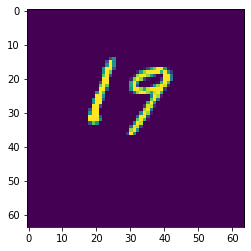

In [18]:
plt.imshow(train_set[2,19,...,0])

In [21]:
model = tf.keras.models.Sequential()
model.add(CausalLSTM(filters=1, #64
                  kernel_size=(3,3),
                  input_shape=(None, 64, 64, 1),
                  padding='same', 
                  return_sequences=True))

model.summary()

STATES: (<tf.Tensor 'causal_lstm_1/convolution:0' shape=(None, 64, 64, 1) dtype=float32>, <tf.Tensor 'causal_lstm_1/convolution:0' shape=(None, 64, 64, 1) dtype=float32>)
STATES SHAPE: 2


StagingError: ignored

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adadelta')

model.fit(train_set[:10], train_set[:10], batch_size=10,
        epochs=300, validation_split=0.05)

In [0]:
model = tf.keras.models.Sequential([
                                    
])
model.add(ConvLSTM2D(filters=1, #64
                  kernel_size=(3,3),
                  input_shape=(None, 64, 64, 1),
                  padding='same', 
                  return_sequences=True))
model.summary()

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adadelta')

model.fit(train_set[:10], train_set[:10], batch_size=10,
        epochs=2, validation_split=0.05)